In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [91]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 15

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"
SIDES_DIR = BASE_DIR / "interm/sides"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"

## Loading Data

In [92]:
%%time
df = pd.read_pickle(RESAMPLED_FILE_PATH)

CPU times: user 611 μs, sys: 1.99 ms, total: 2.61 ms
Wall time: 3.45 ms


In [93]:
df.shape

(24911, 7)

In [94]:
df.head()

,timestamp,open,high,low,close,volume,spread
0,2024-01-01 22:00:00,140.8730,140.8950,140.8655,140.8655,5.462000e+10,0.039259
1,2024-01-01 22:15:00,140.8660,140.9625,140.8660,140.9305,4.103100e+11,0.062629
2,2024-01-01 22:30:00,140.9305,140.9805,140.9015,140.9095,2.649000e+11,0.080043
3,2024-01-01 22:45:00,140.9045,140.9130,140.8825,140.9035,3.124400e+11,0.065611
4,2024-01-01 23:00:00,140.9075,140.9275,140.8175,140.8275,3.040250e+12,0.019193


In [95]:
df["timestamp"] = df["timestamp"].astype("datetime64[s]")
df = df.set_index("timestamp")
df = df.dropna()

## Calculating Signal

In [96]:
import pandas_ta as ta

FAST = 12 #(45 min)
SLOW = 26 #(180 min)

df.ta.ema(length=FAST, append=True)
df.ta.ema(length=SLOW, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"EMA_{FAST}"] > df[f'EMA_{SLOW}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

Profit Factor: 1.0317030634872462
Sharpe Ratio: 0.009233883219526853


## Optimize the strategy

This strategy has 3 parameters: fast, slow, signal

We can optimize the strategy by finding the best combination

In [79]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter ranges to test
fast_range = range(2, 55, 2)      # 8, 10, 12, 14, 16, 18
slow_range = range(24, 169, 2)    # 5, 7, 9, 11, 13

# Store results
results = []

# Grid search optimization
for fast, slow in product(fast_range, slow_range):
    # Skip invalid combinations where fast >= slow
    if fast >= slow:
        continue
    
    # Create a copy of dataframe for testing
    df_test = df.copy()
    
    # Calculate MACD
    df_test.ta.ema(length=fast, append=True)
    df_test.ta.ema(length=slow, append=True)
    
    df_test['future_return'] = np.log(df_test['close']).diff().shift(-1)
    
    ## Generate Signals
    
    df_test['signal'] = np.where(df_test[f"EMA_{fast}"] > df_test[f'EMA_{slow}'], 1, -1)
    
    
    # Calculate strategy returns
    df_test['strategy_return'] = df_test['signal'] * df_test['future_return']
    
    # Calculate metrics
    r = df_test['strategy_return'].dropna()

    
    if len(r) > 0 and r[r < 0].abs().sum() != 0:
        profit_factor = r[r > 0].sum() / r[r < 0].abs().sum()
        sharpe_ratio = r.mean() / r.std() if r.std() != 0 else 0
        total_return = r.sum()
        win_rate = len(r[r > 0]) / len(r)
        
        results.append({
            'fast': fast,
            'slow': slow,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'total_return': total_return,
            'win_rate': win_rate,
            'num_trades': len(r)
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by Sharpe Ratio (or any metric you prefer)
results_df = results_df.sort_values('sharpe_ratio', ascending=False)
# Display top 10 parameter combinations
print("Top 10 Parameter Combinations by Sharpe Ratio:")
print(results_df.head(10).to_string(index=False))

print("\n" + "="*80 + "\n")

# Display top 10 by Profit Factor
print("Top 10 Parameter Combinations by Profit Factor:")
print(results_df.sort_values('profit_factor', ascending=False).head(10).to_string(index=False))

# Get the best parameters
best_params = results_df.iloc[0]
print("\n" + "="*80 + "\n")
print("Best Parameters (by Sharpe Ratio):")
print(f"FAST: {int(best_params['fast'])}")
print(f"SLOW: {int(best_params['slow'])}")
print(f"Sharpe Ratio: {best_params['sharpe_ratio']:.4f}")
print(f"Profit Factor: {best_params['profit_factor']:.4f}")
print(f"Total Return: {best_params['total_return']:.4f}")
print(f"Win Rate: {best_params['win_rate']:.2%}")



Top 10 Parameter Combinations by Sharpe Ratio:
 fast  slow  profit_factor  sharpe_ratio  total_return  win_rate  num_trades
    4    48       1.041977      0.012165      0.202461  0.494580       24910
    8    42       1.041244      0.011957      0.198998  0.495303       24910
   32    88       1.038911      0.011294      0.187958  0.500241       24910
   38    42       1.038706      0.011235      0.186984  0.497511       24910
   36    58       1.038623      0.011211      0.186590  0.498033       24910
   38    76       1.038418      0.011153      0.185619  0.500442       24910
   34    46       1.038388      0.011145      0.185479  0.497912       24910
   40    52       1.038281      0.011114      0.184967  0.498193       24910
    8    44       1.038174      0.011083      0.184461  0.495464       24910
   36    44       1.037772      0.010969      0.182555  0.497431       24910


Top 10 Parameter Combinations by Profit Factor:
 fast  slow  profit_factor  sharpe_ratio  total_return  

<Axes: xlabel='fast', ylabel='slow'>

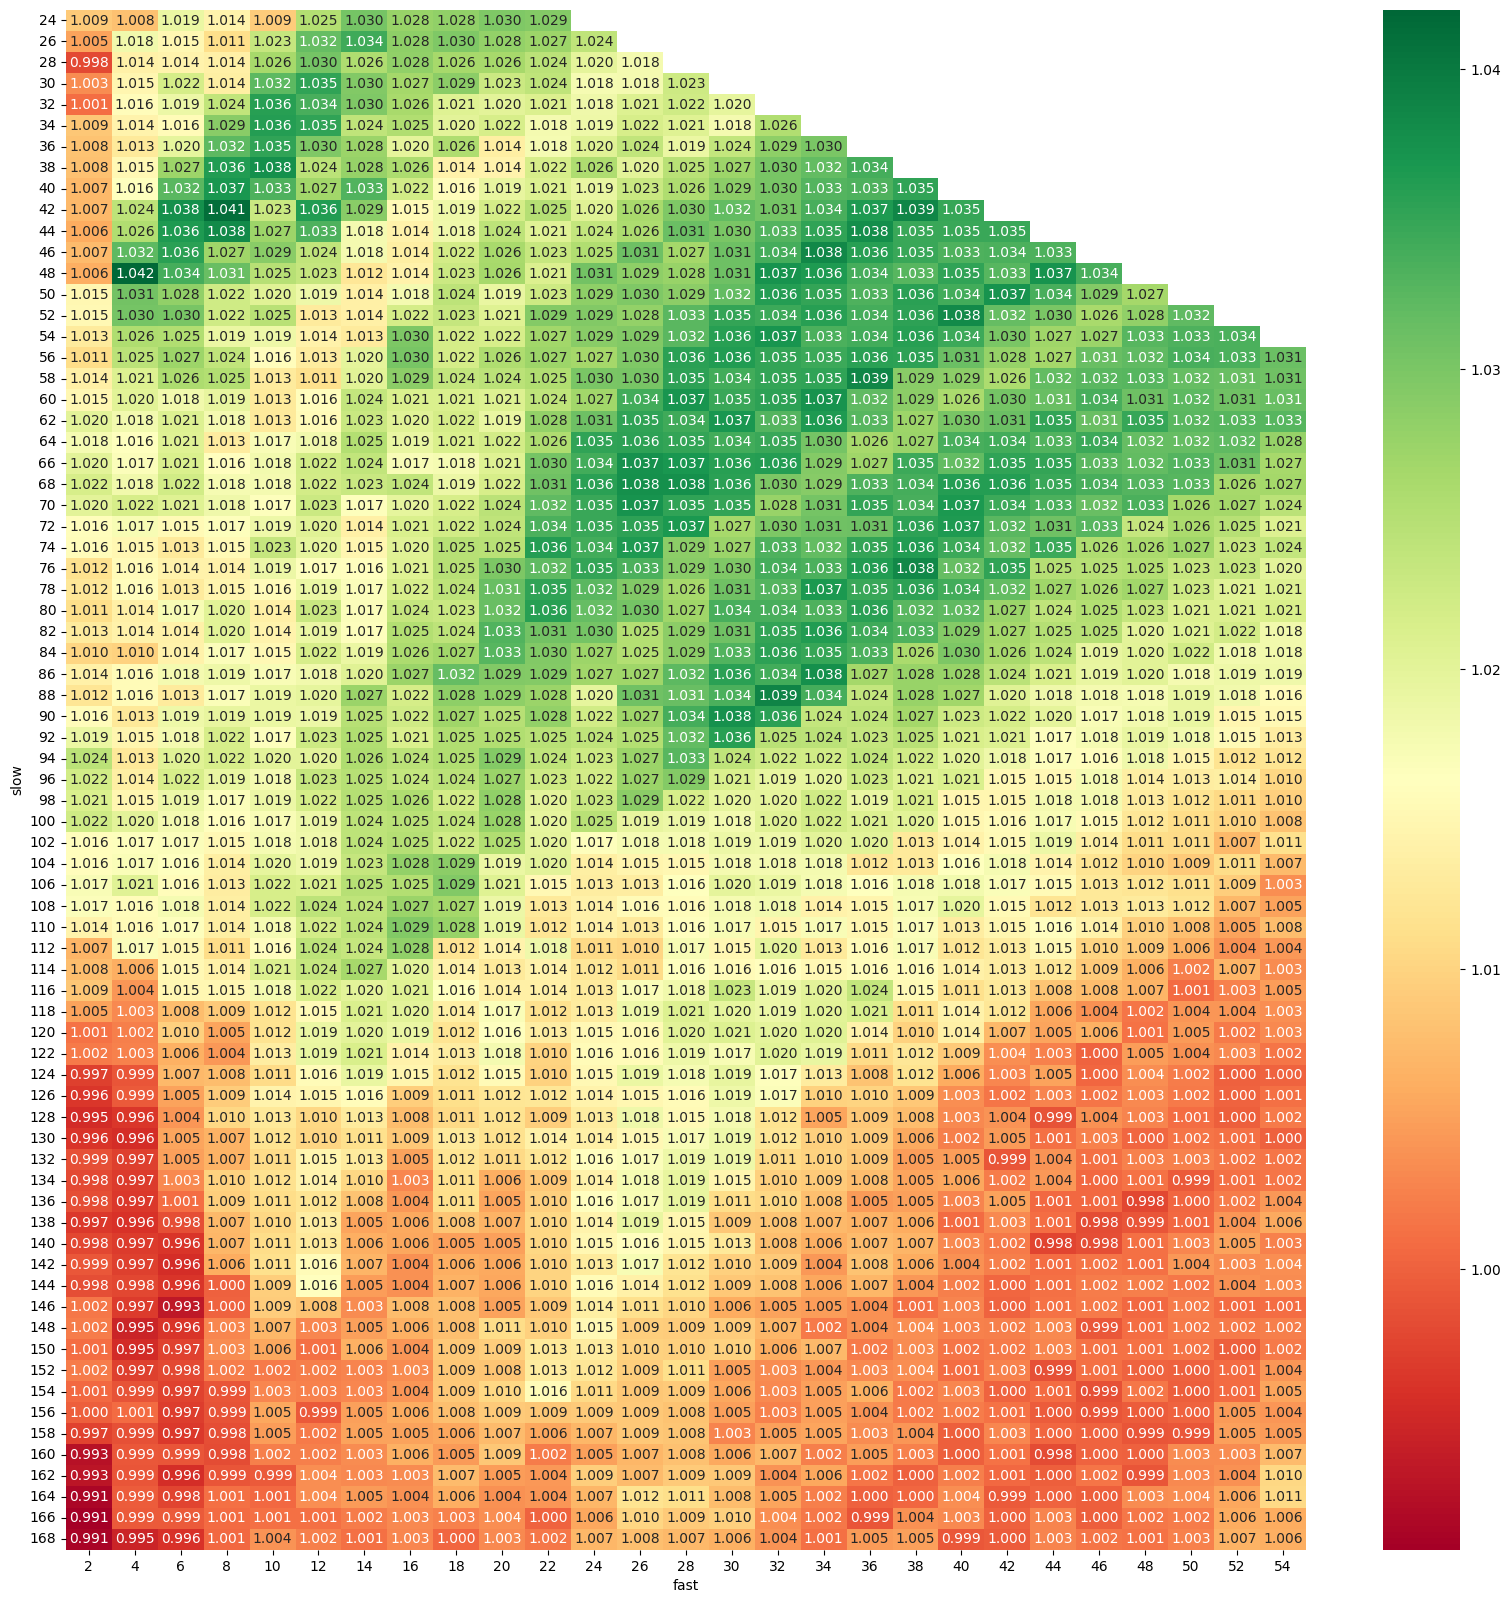

In [90]:
# 2. Heatmap: Profit Factor vs Fast/Slow
plt.figure(figsize=(20,20))
pivot_pf = results_df.pivot(index='slow', columns='fast', values='profit_factor')
sns.heatmap(pivot_pf, annot=True, fmt='.3f', cmap='RdYlGn')


# Reproduce the strategy with optimized parameters

In [81]:
import pandas_ta as ta

FAST = 4 #(45 min)
SLOW = 48 #(180 min)

df.ta.ema(length=FAST, append=True)
df.ta.ema(length=SLOW, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"EMA_{FAST}"] > df[f'EMA_{SLOW}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

Profit Factor: 1.0419769378620611
Sharpe Ratio: 0.012165134757019793


## Finding Cross Points

找到跨越的時間點（t_events）

In [82]:
df['signal'].value_counts()

signal
 1    14176
-1    10735
Name: count, dtype: int64

In [83]:
# find crossover events
t_events = df.index[df['signal'] != df['signal'].shift(1)]
t_events

DatetimeIndex(['2024-01-01 22:00:00', '2024-01-02 09:45:00',
               '2024-01-03 03:45:00', '2024-01-03 05:00:00',
               '2024-01-03 23:00:00', '2024-01-04 00:45:00',
               '2024-01-04 07:30:00', '2024-01-04 08:00:00',
               '2024-01-05 15:00:00', '2024-01-07 23:15:00',
               ...
               '2024-12-27 17:45:00', '2024-12-29 22:15:00',
               '2024-12-29 23:30:00', '2024-12-30 00:15:00',
               '2024-12-30 00:45:00', '2024-12-30 01:45:00',
               '2024-12-30 03:15:00', '2024-12-30 04:30:00',
               '2024-12-30 05:15:00', '2024-12-30 10:00:00'],
              dtype='datetime64[s]', name='timestamp', length=1013, freq=None)

## Labeling Sides

黃金交叉與死亡交叉

In [84]:
sides = pd.Series(df['signal'].loc[t_events], index=t_events, name='side')
sides

timestamp
2024-01-01 22:00:00   -1
2024-01-02 09:45:00    1
2024-01-03 03:45:00   -1
2024-01-03 05:00:00    1
2024-01-03 23:00:00   -1
                      ..
2024-12-30 01:45:00   -1
2024-12-30 03:15:00    1
2024-12-30 04:30:00   -1
2024-12-30 05:15:00    1
2024-12-30 10:00:00   -1
Name: side, Length: 1013, dtype: int64

In [85]:
sides.value_counts()

side
-1    507
 1    506
Name: count, dtype: int64

## Saving to disk

In [86]:
SIDE_NAME = f"EMACross_{FAST}_{SLOW}"

In [87]:
SIDE_FILE_PATH = SIDES_DIR / f"{RESAMPLED_NAME}-{SIDE_NAME}.pkl"
SIDE_FILE_PATH

PosixPath('../data/interm/sides/USDJPY-15m-20240101-20241231-EMACross_4_48.pkl')

In [88]:
sides.to_pickle(SIDE_FILE_PATH)